# Calculate FCM Statistics
*Written by Viviane Clay*
## Preparation
### Import Dependencies

In [12]:
import os
import numpy as np;
import matplotlib.pyplot as plt
from scipy import misc
import matplotlib as mpl
from itertools import combinations 
import pandas as pd
import sklearn.metrics

import warnings
warnings.filterwarnings('ignore')

### Load Data
Get activations using the 'GetNetworkActivations.ipynb' script. Adapt paths as nescessary.

In [2]:
path = '../../Results/TowerTraining/BalancedTestSet/'
figurePath = '../../Results/TowerTraining/Figures/AgentRewardComparisonsAdaTH/ReviewFigures/'

encExt = np.load(path + 'encExt.npy')
encExtInt = np.load(path + 'encExtInt.npy')
encInt = np.load(path + 'encInt.npy')
encAE = np.load(path + 'encAE.npy')
encBYOL = np.load(path + 'encBYOL.npy')
encC = np.load(path + 'encC.npy')
ClassOut = np.load(path + 'outClass.npy')
y = np.load(path + 'labels.npy')
obs = np.load(path + 'obs.npy')
# generate random activations
# randAct = np.random.randint(0,2,encC.shape)
randAct = np.load(path + 'encRand.npy')

### Apply Adaptive Threshold to Activations

In [3]:
c1ActTH = np.mean(encInt, axis = 0)
c2ActTH = np.mean(encExt, axis = 0)
c3ActTH = np.mean(encExtInt, axis = 0)
AEActTH = np.mean(encAE, axis = 0)
BYOLActTH = np.mean(encBYOL, axis = 0)
CActTH = np.mean(encC, axis = 0)
RActTH = np.mean(randAct, axis = 0)

encInt = np.array(np.abs(encInt) > np.abs(c1ActTH),dtype=int)
encExt = np.array(np.abs(encExt) > np.abs(c2ActTH),dtype=int)
encExtInt = np.array(np.abs(encExtInt) > np.abs(c3ActTH),dtype=int)
encAE = np.array(np.abs(encAE) > np.abs(AEActTH),dtype=int)
encBYOL = np.array(np.abs(encBYOL) > np.abs(BYOLActTH),dtype=int)
encC = np.array(np.abs(encC) > np.abs(CActTH),dtype=int)
encR = np.array(np.abs(randAct) > np.abs(RActTH),dtype=int)

### Helper Functions

In [9]:
def getEdges(encodings):
    TH = 0.5
    comb = combinations(np.linspace(0,encodings.shape[1]-1,encodings.shape[1]), 2)
    c = list(comb)
    edges = np.zeros(len(c))  

    for i in range(encodings.shape[0]):
        for n in range(len(c)):
            a = int(c[n][0])
            b = int(c[n][1])
            if (encodings[i][a]>TH) & (encodings[i][b]>TH):
                edges[n] = edges[n]+1
    return edges,c

def learnConcept(examples, name, pattern_complexity,normalize = False):
    e,c = getEdges(examples)
    strongest = e.argsort()[-pattern_complexity:][::-1]
    strongest_combs = []
    strengths = []
    #print('Combinations:      Strength:')
    for s in strongest:
        #print(str(c[s]) + '        ' + str(int(e[s])))
        strongest_combs.append(c[s])
        strengths.append(int(e[s]))
    if normalize:
        strengths = strengths/np.sum(strengths)
    else:
        strengths = np.array(strengths)/examples.shape[0]
    return strongest_combs, strengths


def getActsLogic(neuronCombs, strengths, data, class_TH):
    patternOn = np.zeros(data.shape[0])
    for i,n in enumerate(neuronCombs):
        n1_act = (data[:,int(n[0])] > 0.5)
        n2_act = (data[:,int(n[1])] > 0.5)
        n_act = np.array(n1_act & n2_act, dtype=int) * strengths[i]
        patternOn = patternOn + n_act
    patternOn = (patternOn >= class_TH)
    return patternOn

def plotPatternActsLogic(patternOn, labels):
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(patternOn)
    plt.plot(labels/2)
    plt.xlim([0,labels.shape[0]])
    plt.ylim([0,1.1])
    plt.legend(['Pattern On', 'Label Present'])
    plt.yticks([])
    plt.xlabel('Frames')
    
    plt.subplot(1,2,2)
    c = plt.hist(patternOn + labels/2, bins = [0,0.5,1,1.5,2])
    plt.xticks([0.25,0.75,1.25,1.75],['TN', 'FN', 'FP','TP'])
    correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
    precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
    recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
    plt.title('Correct: ' + str(correct) + '% Precision: ' + str(precision) + '% Recall: ' + str(recall) + '%')
    plt.show()
    
def plotCPR(combs, weights, enc, labels, THs):
    cpr = np.zeros((THs.shape[0],3))
    for i,TH in enumerate(THs):
        patternOn = getActsLogic(combs, weights, enc, class_TH=TH)
        c = plt.hist(patternOn + labels/2, bins = [0,0.5,1,1.5,2])
        
        correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
        precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
        recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
        
        cpr[i] = np.array([correct,precision,recall])
    plt.clf()
    plt.figure(figsize=(15,5))
    plt.plot(cpr)
    plt.legend(['% Correct', 'Precision', 'Recall'])
    plt.xticks(np.linspace(0,THs.shape[0]-1,THs.shape[0]),np.round(THs,2))
    plt.xlim([0,THs.shape[0]-1])
    plt.ylim([0,100])
    plt.xlabel('Threshold')
    plt.ylabel('Performance [Accuracy in %]')
    plt.show()
    
def getCPR(combs, weights, enc, labels, THs,pattern):
    cpr = np.zeros((THs.shape[0],5))
    for i,TH in enumerate(THs):
        if pattern=='single':
            patternOn = getSingleActsLogic(combs, weights, enc, class_TH=TH)
        elif pattern=='double':
            patternOn = getActsLogic(combs, weights, enc, class_TH=TH)
        elif pattern=='triple':
            patternOn = getTripletsActsLogic(combs, weights, enc, class_TH=TH)
        else:
            print('unknown pattern identifier.')
            break
        c = plt.hist(patternOn + labels/2, bins = [0,0.5,1,1.5,2])
        
        correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
        precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
        recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
        f1score = np.round(2*(precision*recall/(precision+recall)),2)
        
        cpr[i] = np.array([correct,precision,recall,correct+precision+recall,f1score])
    plt.close()
    return np.nan_to_num(cpr)

def getCPR_THs(measure, labels, THs):
    cpr = np.zeros((THs.shape[0],5))
    for i,TH in enumerate(THs):
        classification = measure >= TH
        c = plt.hist(classification + labels/2, bins = [0,0.5,1,1.5,2])
        
        correct = np.round((c[0][0] + c[0][3])/labels.shape[0]*100,2)
        precision = np.round(c[0][3]/(c[0][3]+c[0][2])*100,2)# If L is predicted it is correct X% of time
        recall = np.round(c[0][3]/(c[0][3]+c[0][1])*100,2)# Correctly identifies X% of L
        f1score = np.round(2*(precision*recall/(precision+recall)),2)
        
        cpr[i] = np.array([correct,precision,recall,correct+precision+recall,f1score])
    plt.close()
    return np.nan_to_num(cpr)

def getConceptSubset(AllConceptExamples, numExp):
    subset = np.random.randint(0,AllConceptExamples.shape[0],numExp)
    trainExp = AllConceptExamples[subset]
    mask = np.ones(AllConceptExamples.shape, bool)
    mask[subset] = False
    testExp = AllConceptExamples[mask]
    return trainExp,  testExp

def getFP_FN(o,l):
    w = np.where(l!=o)
    FN = np.sum((o[w]==0)&(l[w]==1))/len(w[0])*100
    FP = np.sum((o[w]>0)&(l[w]==0))/len(w[0])*100
    return np.round(FP,3),np.round(FN,3)

def getAccPR(o,l):
    w = np.where(l!=o)
    trueP = np.sum((o==l)&(o==1))
    trueN = np.sum((o==l)&(o==0))
    falseP = np.sum((o[w]>0)&(l[w]==0))
    falseN = np.sum((o[w]==0)&(l[w]==1))
    Acc = (trueP+trueN)/len(o)*100
    Precision = trueP/(trueP+falseP)*100
    Recall = trueP/(trueP+falseN)*100
    return np.round(Acc,3),np.round(Precision,3),np.round(Recall,3),[trueP,trueN,falseP,falseN]

def printStats(out, labels):
    print('Accuracy: '+str(np.mean(out == labels)*100)+'%')
    print('Everything correct in '+str(np.sum(np.mean(out == labels,axis=1)==1.0)/len(labels)*100)+'%')
    print('Correct Door in '+str(np.round(np.mean(np.array(labels)[:,0]==out[:,0])*100,3))+'%')

    AccND,PND,RND,NDA = getAccPR((out[:,0]==0).astype(int),(labels[:,0]==0).astype(int))
    print('     No Door - Acc: '+str(AccND)+'% Precision: '+str(PND)+'% Recall: '+str(RND)+'%  |  TP,TN,FP,FN: '+str(NDA))

    AccLD,PLD,RLD,LDA = getAccPR((out[:,0]==1).astype(int),(labels[:,0]==1).astype(int))
    print('     Level Door - Acc: '+str(AccLD)+'% Precision: '+str(PLD)+'% Recall: '+str(RLD)+'%  |  TP,TN,FP,FN: '+str(LDA))

    AccGD,PGD,RGD,GDA = getAccPR((out[:,0]==2).astype(int),(labels[:,0]==2).astype(int))
    print('     Green Door - Acc: '+str(AccGD)+'% Precision: '+str(PGD)+'% Recall: '+str(RGD)+'%  |  TP,TN,FP,FN: '+str(GDA))

    AccKD,PKD,RKD,KDA = getAccPR((out[:,0]==3).astype(int),(labels[:,0]==3).astype(int))
    print('     Key Door - Acc: '+str(AccKD)+'% Precision: '+str(PKD)+'% Recall: '+str(RKD)+'%  |  TP,TN,FP,FN: '+str(KDA))

    AccOD,POD,ROD,ODA = getAccPR((out[:,0]==4).astype(int),(labels[:,0]==4).astype(int))
    print('     Other Door - Acc: '+str(AccOD)+'% Precision: '+str(POD)+'% Recall: '+str(ROD)+'%  |  TP,TN,FP,FN: '+str(ODA))

    AccK,PK,RK,KA = getAccPR(out[:,1],np.array(labels)[:,1])
    print('Correct Key in '+str(AccK)+'% - Precision: '+
          str(PK)+'% Recall: '+str(RK)+'%  |  TP,TN,FP,FN: '+str(KA))

    AccO,PO,RO,OA = getAccPR(out[:,2],np.array(labels)[:,2])
    print('Correct Orb in '+str(AccO)+'% - Precision: '+
          str(PO)+'% Recall: '+str(RO)+'%  |  TP,TN,FP,FN: '+str(OA))
    
def getStats(out, labels):

    AccND,PND,RND,NDA = getAccPR((out[:,0]==0).astype(int),(labels[:,0]==0).astype(int))
    
    AccLD,PLD,RLD,LDA = getAccPR((out[:,0]==1).astype(int),(labels[:,0]==1).astype(int))

    AccGD,PGD,RGD,GDA = getAccPR((out[:,0]==2).astype(int),(labels[:,0]==2).astype(int))

    AccKD,PKD,RKD,KDA = getAccPR((out[:,0]==3).astype(int),(labels[:,0]==3).astype(int))

    AccOD,POD,ROD,ODA = getAccPR((out[:,0]==4).astype(int),(labels[:,0]==4).astype(int))

    AccK,PK,RK,KA = getAccPR(out[:,1],np.array(labels)[:,1])

    AccO,PO,RO,OA = getAccPR(out[:,2],np.array(labels)[:,2])
    
    precisions = np.nan_to_num(np.array([PND, PLD, PGD, PKD, POD, PK, PO]))
    recalls = np.nan_to_num(np.array([RND, RLD, RGD, RKD, ROD, RK, RO]))
    f1scores = np.nan_to_num(np.round(2*(precisions*recalls/(precisions+recalls)),2))
    
    stats = {'Accuracy': np.mean(out == labels)*100,
            'Accuracies': np.array([AccND, AccLD, AccGD, AccKD, AccOD, AccK, AccO]),
            'Precisions': precisions,
            'Recalls': recalls,
            'F1Scores': f1scores}
    return stats


### Learning Concepts
#### Cosine Similarity

In [5]:
def LearnAllConceptsCosineSim(numExp, encoding, to_learn, concept_def):
    allConcepts = []
        
    for i, concept in enumerate(to_learn):
        learnExamples, testExamples = getConceptSubset(np.where(concept_def[i])[0], numExp)

        examples = encoding[learnExamples]
        labels_test = concept_def[i]

        centroid = np.mean(examples, axis=0)
        cosineSims = sklearn.metrics.pairwise.cosine_similarity(centroid.reshape(1, -1), encoding)[0]
        #classification = cosineSims >= TH
        
        true_exp = np.where(labels_test==True)[0]
        false_exp = np.where(labels_test==False)[0]
        np.random.shuffle(false_exp)
        balanced_exp = np.append(true_exp,false_exp[:true_exp.shape[0]])

        cpr_test = getCPR_THs(cosineSims[balanced_exp], labels_test[balanced_exp],np.linspace(0,1,21))

        ConceptStats = {'Concept':concept,
                     'Examples': learnExamples,
                     'CPR_Test': cpr_test}

        allConcepts.append(ConceptStats)
    return allConcepts

In [10]:
import sklearn.metrics

In [11]:
allConceptsCosSim = LearnAllConceptsCosineSim(5, encInt, to_learn, concept_def)

## FCM
### Define Parameters

In [6]:
to_learn = ['Level Door', 'Green Door', 'Key Door', 'Other Door', 'Key', 'Orb']#'No Door', 
concept_def = [y[:,0]==1, y[:,0]==2, y[:,0]==3, y[:,0]==4, y[:,1]==1, y[:,2]==1]#y[:,0]==0, 
numExp_default = 5

### Find Best TH for Each Condition

In [17]:
numRuns = 100
bestTHStatsAEBCR_TH = pd.DataFrame(columns = {'Concept','Encoding', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall'})

for numExp in [numExp_default]:
    for i in range(numRuns):
        allConcepts = LearnAllConceptsCosineSim(numExp, encInt, to_learn, concept_def)
        allConceptsAE = LearnAllConceptsCosineSim(numExp, encAE, to_learn, concept_def)
        allConceptsBYOL = LearnAllConceptsCosineSim(numExp, encBYOL, to_learn, concept_def)
        allConceptsC = LearnAllConceptsCosineSim(numExp, encC, to_learn, concept_def)
        allConceptsR = LearnAllConceptsCosineSim(numExp, encR, to_learn, concept_def)
        for c in allConcepts:
            for i,THTest in enumerate(c['CPR_Test']):
                bestTHStatsAEBCR_TH = bestTHStatsAEBCR_TH.append({'Concept': c['Concept'],'Encoding':'Agent', 'Examples': c['Examples'],'NumExp':numExp,
                                                'TH': np.round(np.linspace(0,1,21)[i],2),
                                                'Accuracy': THTest[0], 'Precision': THTest[1],
                                                'Recall': THTest[2]},ignore_index=True)
            
        for c in allConceptsAE:
            for i,THTest in enumerate(c['CPR_Test']):
                bestTHStatsAEBCR_TH = bestTHStatsAEBCR_TH.append({'Concept': c['Concept'],'Encoding':'Autoencoder', 'Examples': c['Examples'],'NumExp':numExp,
                                                'TH': np.round(np.linspace(0,1,21)[i],2),
                                                'Accuracy': THTest[0], 'Precision': THTest[1],
                                                'Recall': THTest[2]},ignore_index=True)

        for c in allConceptsBYOL:
            for i,THTest in enumerate(c['CPR_Test']):
                bestTHStatsAEBCR_TH = bestTHStatsAEBCR_TH.append({'Concept': c['Concept'],'Encoding':'BYOL', 'Examples': c['Examples'],'NumExp':numExp,
                                                'TH': np.round(np.linspace(0,1,21)[i],2),
                                                'Accuracy': THTest[0], 'Precision': THTest[1],
                                                'Recall': THTest[2]},ignore_index=True)
            
        for c in allConceptsC:
            for i,THTest in enumerate(c['CPR_Test']):
                bestTHStatsAEBCR_TH = bestTHStatsAEBCR_TH.append({'Concept': c['Concept'],'Encoding':'Classifier', 'Examples': c['Examples'],'NumExp':numExp,
                                                'TH': np.round(np.linspace(0,1,21)[i],2),
                                                'Accuracy': THTest[0], 'Precision': THTest[1],
                                                'Recall': THTest[2]},ignore_index=True)
        for c in allConceptsR:
            for i,THTest in enumerate(c['CPR_Test']):
                bestTHStatsAEBCR_TH = bestTHStatsAEBCR_TH.append({'Concept': c['Concept'],'Encoding':'Random', 'Examples': c['Examples'],'NumExp':numExp,
                                                'TH': np.round(np.linspace(0,1,21)[i],2),
                                                'Accuracy': THTest[0], 'Precision': THTest[1],
                                                'Recall': THTest[2]},ignore_index=True)


In [18]:
bestTHStatsAEBCR_TH.to_csv(figurePath+'bestTHStatsAEBCRNormx2_TH_Cosine.csv')

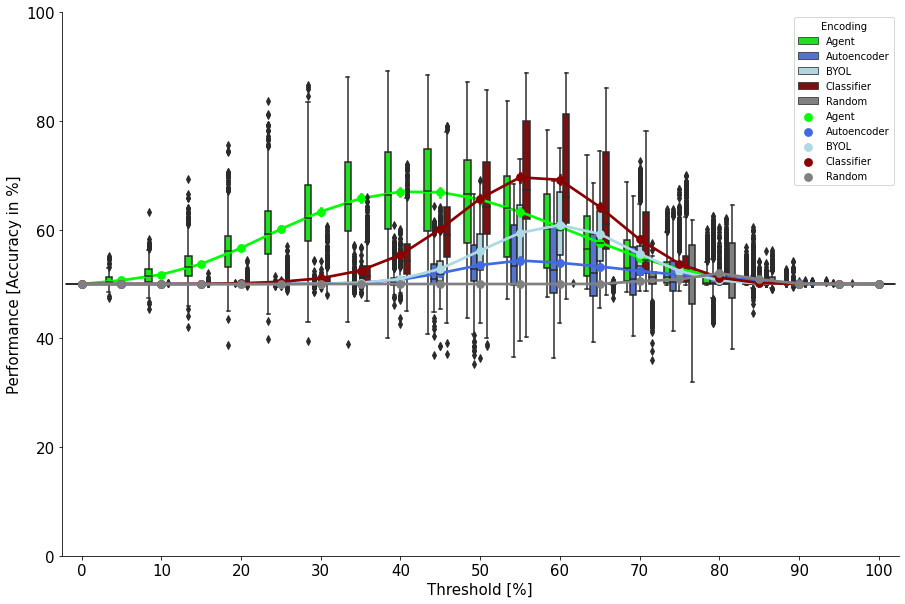

In [19]:
import seaborn as sns
all_colors = ['lime','royalblue','lightblue','darkred','grey','purple']
colors = [all_colors[0],all_colors[1],all_colors[2],all_colors[3],all_colors[4]]
data = bestTHStatsAEBCR_TH#[bestTHStatsAEBCR_TH['Concept']=='Level Door']

plt.figure(figsize=(15,10))
ax1 = sns.boxplot(data=data,x='TH',y='Accuracy',hue='Encoding',palette=colors)
ax2 = sns.pointplot(data=data,x='TH',y='Accuracy',hue='Encoding',palette=colors)
plt.xlabel('Threshold [%]',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0,100])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xticks(np.linspace(0,20,11),np.linspace(0,100,11,dtype=int),fontsize=15)
plt.show()

In [21]:
for e in bestTHStatsAEBCR_TH['Encoding'].unique():
    data = bestTHStatsAEBCR_TH[bestTHStatsAEBCR_TH['Encoding']==e]
    print(e)
    bestTH = 0
    bestTHInd = 0
    for th in np.linspace(0,1,21):
        dataTH = data[data['TH']==np.round(th,2)]
        if np.mean(dataTH['Accuracy']) > bestTH:
            bestTH = np.mean(dataTH['Accuracy'])
            bestTHInd = th
            #print("updated to th = " + str(bestTHInd))
    print("Best TH=" + str(np.round(bestTHInd,2)) + " with mean Accuracy= " + str(bestTH))


Agent
Best TH=0.4 with mean Accuracy= 66.97133333333333
Autoencoder
Best TH=0.55 with mean Accuracy= 54.31133333333332
BYOL
Best TH=0.6 with mean Accuracy= 60.83899999999999
Classifier
Best TH=0.55 with mean Accuracy= 69.61866666666666
Random
Best TH=0.8 with mean Accuracy= 51.982


### FCM on all Conditions with Best TH

In [26]:
numRuns = 100
bestIndvTHStatsAEBCR = pd.DataFrame(columns = {'Concept','Encoding', 'Examples','NumExp','TH', 
                                    'Accuracy', 'Precision', 'Recall','CPR','F1Score'})

for numExp in [numExp_default]:
    for i in range(numRuns):
        print(i)
        allConcepts = LearnAllConceptsCosineSim(numExp, encInt, to_learn, concept_def)
        allConceptsAE = LearnAllConceptsCosineSim(numExp, encAE, to_learn, concept_def)
        allConceptsBYOL = LearnAllConceptsCosineSim(numExp, encBYOL, to_learn, concept_def)
        allConceptsC = LearnAllConceptsCosineSim(numExp, encC, to_learn, concept_def)
        allConceptsR = LearnAllConceptsCosineSim(numExp, encR, to_learn, concept_def)
        for c in allConcepts:
            TH20 = c['CPR_Test'][8]
            bestIndvTHStatsAEBCR = bestIndvTHStatsAEBCR.append({'Concept': c['Concept'],
                                                                        'Encoding':'Agent',
                                                                        'Examples': c['Examples'],
                                                                        'NumExp':numExp,'TH': 0.4,
                                                                        'Accuracy': TH20[0],
                                                                        'Precision': TH20[1],
                                                                        'Recall': TH20[2],
                                                                        'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
            
        for c in allConceptsAE:
            TH20 = c['CPR_Test'][11]
            bestIndvTHStatsAEBCR = bestIndvTHStatsAEBCR.append({'Concept': c['Concept'],
                                                                        'Encoding':'Autoencoder',
                                                                        'Examples': c['Examples'],
                                                                        'NumExp':numExp,'TH': 0.55,
                                                                        'Accuracy': TH20[0],
                                                                        'Precision': TH20[1],
                                                                        'Recall': TH20[2],
                                                                        'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)

        for c in allConceptsBYOL:
            TH20 = c['CPR_Test'][12]
            bestIndvTHStatsAEBCR = bestIndvTHStatsAEBCR.append({'Concept': c['Concept'],
                                                                        'Encoding':'BYOL',
                                                                        'Examples': c['Examples'],
                                                                        'NumExp':numExp,'TH': 0.6,
                                                                        'Accuracy': TH20[0],
                                                                        'Precision': TH20[1],
                                                                        'Recall': TH20[2],
                                                                        'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
            
        for c in allConceptsC:
            TH20 = c['CPR_Test'][11]
            bestIndvTHStatsAEBCR = bestIndvTHStatsAEBCR.append({'Concept': c['Concept'],
                                                                        'Encoding':'Classifier',
                                                                        'Examples': c['Examples'],
                                                                        'NumExp':numExp,'TH': 0.55,
                                                                        'Accuracy': TH20[0],
                                                                        'Precision': TH20[1],
                                                                        'Recall': TH20[2],
                                                                        'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
        
        for c in allConceptsR:
            TH20 = c['CPR_Test'][16]
            bestIndvTHStatsAEBCR = bestIndvTHStatsAEBCR.append({'Concept': c['Concept'],
                                                                        'Encoding':'Random',
                                                                        'Examples': c['Examples'],
                                                                        'NumExp':numExp,'TH': 0.8,
                                                                        'Accuracy': TH20[0],
                                                                        'Precision': TH20[1],
                                                                        'Recall': TH20[2],
                                                                        'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [27]:
bestIndvTHStatsAEBCR.to_csv(figurePath+'bestIndvTHStatsAEBCR_Cosine.csv')

In [28]:
import matplotlib.patches as mpatches

In [29]:
figurePath = '../../Results/TowerTraining/Figures/AgentRewardComparisonsAdaTH/ReviewFigures/Final/'
saveFigs = True
figureFormat = '.png'#'.eps'
dpi = 100 #300 for production
all_colors = ['lime','royalblue','lightblue','darkred','grey','purple']
all_conditions = ['Agent','Autoencoder', 'BYOL','Classifier','Random','Classifier Out']

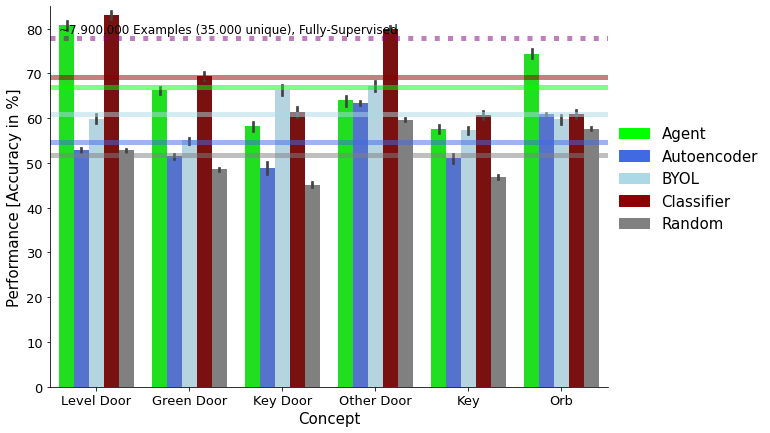

In [33]:
bestIndvTHStatsAEBCR_Sorted = pd.concat([bestIndvTHStatsAEBCR[bestIndvTHStatsAEBCR['Encoding']=='Agent'],
                                bestIndvTHStatsAEBCR[bestIndvTHStatsAEBCR['Encoding']=='Autoencoder'],
                                bestIndvTHStatsAEBCR[bestIndvTHStatsAEBCR['Encoding']=='BYOL'],
                                bestIndvTHStatsAEBCR[bestIndvTHStatsAEBCR['Encoding']=='Classifier'],
                                bestIndvTHStatsAEBCR[bestIndvTHStatsAEBCR['Encoding']=='Random'],])
classifier_stats = np.load(figurePath+'classifier_stats.npy',allow_pickle='TRUE').item()
colorsbar = all_colors[:-1]

plt.figure(figsize=(10,7))

ax1 = sns.barplot(data=bestIndvTHStatsAEBCR_Sorted,x='Concept',y='Accuracy',hue='Encoding',palette=colorsbar)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xlabel('Concept',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlim([-0.5,5.5])
plt.ylim([0,85])
legend_labels = ['Agent', 'Autoencoder','BYOL','Classifier','Random']
values = np.linspace(1,5,5)
patches = [ mpatches.Patch(color=all_colors[i], label=legend_labels[i] ) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.01, 0.7), loc=2, borderaxespad=0. ,
           title_fontsize=15,fontsize=15,frameon=False,ncol=1)

randMean = np.mean(bestIndvTHStatsAEBCR_Sorted[bestIndvTHStatsAEBCR_Sorted['Encoding']=='Random']['Accuracy'])
plt.plot([-0.5,7],[randMean, randMean],color=all_colors[4],lw=5,alpha=0.5)

AEMean = np.mean(bestIndvTHStatsAEBCR_Sorted[bestIndvTHStatsAEBCR_Sorted['Encoding']=='Autoencoder']['Accuracy'])
plt.plot([-0.5,7],[AEMean, AEMean],color=all_colors[1],lw=5,alpha=0.5)

BYOLMean = np.mean(bestIndvTHStatsAEBCR_Sorted[bestIndvTHStatsAEBCR_Sorted['Encoding']=='BYOL']['Accuracy'])
plt.plot([-0.5,7],[BYOLMean, BYOLMean],color=all_colors[2],lw=5,alpha=0.5)

AgentMean = np.mean(bestIndvTHStatsAEBCR_Sorted[bestIndvTHStatsAEBCR_Sorted['Encoding']=='Agent']['Accuracy'])
plt.plot([-0.5,7],[AgentMean, AgentMean],color=all_colors[0],lw=5,alpha=0.5)

ClassifierMean = np.mean(bestIndvTHStatsAEBCR_Sorted[bestIndvTHStatsAEBCR_Sorted['Encoding']=='Classifier']['Accuracy'])
plt.plot([-0.5,7],[ClassifierMean, ClassifierMean],color=all_colors[3],lw=5,alpha=0.5)

ClassOutMean = np.mean(classifier_stats['Accuracies'][1:])#exclude no door concept
plt.plot([-0.5,7],[ClassOutMean, ClassOutMean],color='purple',lw=5,alpha=0.5,ls=':')

plt.text(-0.4,79,'~7.900.000 Examples (35.000 unique), Fully-Supervised',fontsize=12)


plt.show() if not saveFigs else plt.savefig(figurePath+'AVG_AccC_AEBCR_IndvTH_Cosine' + figureFormat, bbox_inches='tight', dpi=dpi)

### FCM on all Activations for Different Numbers of Examples

In [62]:
numRuns = 100
bestTHStatsAEBCR_numExp = pd.DataFrame(columns = {'Concept','Encoding','PC', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall','CPR','F1Score'})

to_learnD = [to_learn[0]]
concept_defD = [concept_def[0]]
for pattern_complexity in [pattern_complexity_default]:
    for numExp in [1,2,3,4,5,10,15,20,50]:
        for i in range(numRuns):
            print(i)
            allConcepts = LearnAllConcepts(numExp, pattern_complexity, encInt, to_learnD, concept_defD)
            allConceptsAE = LearnAllConcepts(numExp, pattern_complexity, encAE, to_learnD, concept_defD)
            allConceptsBYOL = LearnAllConcepts(numExp, pattern_complexity, encBYOL, to_learnD, concept_defD)
            allConceptsC = LearnAllConcepts(numExp, pattern_complexity, encC, to_learnD, concept_defD)
            allConceptsR = LearnAllConcepts(numExp, pattern_complexity, encR, to_learnD, concept_defD)
            for c in allConcepts:
                if c['Concept']=='Level Door':
                    TH20 = c['CPR_Test'][3]
                    bestTHStatsAEBCR_numExp = bestTHStatsAEBCR_numExp.append({'Concept': c['Concept'],
                                                                            'Encoding':'Agent',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.15,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
            
            for c in allConceptsAE:
                if c['Concept']=='Level Door':
                    TH20 = c['CPR_Test'][6]
                    bestTHStatsAEBCR_numExp = bestTHStatsAEBCR_numExp.append({'Concept': c['Concept'],
                                                                            'Encoding':'Autoencoder',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.3,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)

            for c in allConceptsBYOL:
                if c['Concept']=='Level Door':
                    TH20 = c['CPR_Test'][7]
                    bestTHStatsAEBCR_numExp = bestTHStatsAEBCR_numExp.append({'Concept': c['Concept'],
                                                                            'Encoding':'BYOL',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.35,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
                
            for c in allConceptsC:
                if c['Concept']=='Level Door':
                    TH20 = c['CPR_Test'][5]
                    bestTHStatsAEBCR_numExp = bestTHStatsAEBCR_numExp.append({'Concept': c['Concept'],
                                                                            'Encoding':'Classifier',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.25,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
            for c in allConceptsR:
                if c['Concept']=='Level Door':
                    TH20 = c['CPR_Test'][18]
                    bestTHStatsAEBCR_numExp = bestTHStatsAEBCR_numExp.append({'Concept': c['Concept'],
                                                                            'Encoding':'Random',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.9,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

In [63]:
bestTHStatsAEBCR_numExp.to_csv(figurePath+'bestTHStatsAEBCR_numExp_LDoor.csv')

### FCM on all Activations for Different Pattern Complexities

In [55]:
numRuns = 100
bestTHStatsAEBCR_PCComp_AllC = pd.DataFrame(columns = {'Concept','Encoding','PC', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall','CPR','F1Score'})

for pattern_complexity in [1,2,3,4,5,10,15,20]:
    for numExp in [numExp_default]:
        for i in range(numRuns):
            print(str(pattern_complexity) + ' - ' + str(i))
            allConcepts = LearnAllConcepts(numExp, pattern_complexity, encInt, to_learn, concept_def)
            allConceptsAE = LearnAllConcepts(numExp, pattern_complexity, encAE, to_learn, concept_def)
            allConceptsBYOL = LearnAllConcepts(numExp, pattern_complexity, encBYOL, to_learn, concept_def)
            allConceptsC = LearnAllConcepts(numExp, pattern_complexity, encC, to_learn, concept_def)
            allConceptsR = LearnAllConcepts(numExp, pattern_complexity, encR, to_learn, concept_def)
            for c in allConcepts:
                TH20 = c['CPR_Test'][3]
                bestTHStatsAEBCR_PCComp_AllC = bestTHStatsAEBCR_PCComp_AllC.append({'Concept': c['Concept'],
                                                                            'Encoding':'Agent',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.5,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
                
            for c in allConceptsAE:
                TH20 = c['CPR_Test'][6]
                bestTHStatsAEBCR_PCComp_AllC = bestTHStatsAEBCR_PCComp_AllC.append({'Concept': c['Concept'],
                                                                            'Encoding':'Autoencoder',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.3,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)

            for c in allConceptsBYOL:
                TH20 = c['CPR_Test'][7]
                bestTHStatsAEBCR_PCComp_AllC = bestTHStatsAEBCR_PCComp_AllC.append({'Concept': c['Concept'],
                                                                            'Encoding':'BYOL',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.35,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
                
            for c in allConceptsC:
                TH20 = c['CPR_Test'][5]
                bestTHStatsAEBCR_PCComp_AllC = bestTHStatsAEBCR_PCComp_AllC.append({'Concept': c['Concept'],
                                                                            'Encoding':'Classifier',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.25,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
            for c in allConceptsR:
                TH20 = c['CPR_Test'][18]
                bestTHStatsAEBCR_PCComp_AllC = bestTHStatsAEBCR_PCComp_AllC.append({'Concept': c['Concept'],
                                                                            'Encoding':'Random',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.9,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)

    

1 - 0
1 - 1
1 - 2
1 - 3
1 - 4
1 - 5
1 - 6
1 - 7
1 - 8
1 - 9
1 - 10
1 - 11
1 - 12
1 - 13
1 - 14
1 - 15
1 - 16
1 - 17
1 - 18
1 - 19
1 - 20
1 - 21
1 - 22
1 - 23
1 - 24
1 - 25
1 - 26
1 - 27
1 - 28
1 - 29
1 - 30
1 - 31
1 - 32
1 - 33
1 - 34
1 - 35
1 - 36
1 - 37
1 - 38
1 - 39
1 - 40
1 - 41
1 - 42
1 - 43
1 - 44
1 - 45
1 - 46
1 - 47
1 - 48
1 - 49
1 - 50
1 - 51
1 - 52
1 - 53
1 - 54
1 - 55
1 - 56
1 - 57
1 - 58
1 - 59
1 - 60
1 - 61
1 - 62
1 - 63
1 - 64
1 - 65
1 - 66
1 - 67
1 - 68
1 - 69
1 - 70
1 - 71
1 - 72
1 - 73
1 - 74
1 - 75
1 - 76
1 - 77
1 - 78
1 - 79
1 - 80
1 - 81
1 - 82
1 - 83
1 - 84
1 - 85
1 - 86
1 - 87
1 - 88
1 - 89
1 - 90
1 - 91
1 - 92
1 - 93
1 - 94
1 - 95
1 - 96
1 - 97
1 - 98
1 - 99
2 - 0
2 - 1
2 - 2
2 - 3
2 - 4
2 - 5
2 - 6
2 - 7
2 - 8
2 - 9
2 - 10
2 - 11
2 - 12
2 - 13
2 - 14
2 - 15
2 - 16
2 - 17
2 - 18
2 - 19
2 - 20
2 - 21
2 - 22
2 - 23
2 - 24
2 - 25
2 - 26
2 - 27
2 - 28
2 - 29
2 - 30
2 - 31
2 - 32
2 - 33
2 - 34
2 - 35
2 - 36
2 - 37
2 - 38
2 - 39
2 - 40
2 - 41
2 - 42
2 - 43
2 - 44
2 - 4

In [56]:
bestTHStatsAEBCR_PCComp_AllC.to_csv(figurePath+'bestIndvTHStatsAEBCR_PCComp_AllC.csv')

### FCM on Different Agent Reward Types
#### Find optimal THs

In [20]:
numRuns = 100
bestTHStatsAgents = pd.DataFrame(columns = {'Concept','Encoding','Pattern Complexity', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall'})

for pattern_complexity in [pattern_complexity_default]:
    for numExp in [numExp_default]:
        for i in range(numRuns):
            allConceptsInt = LearnAllConcepts(numExp, pattern_complexity, encInt, to_learn, concept_def)
            allConceptsExt = LearnAllConcepts(numExp, pattern_complexity, encExt, to_learn, concept_def)
            allConceptsIntExt = LearnAllConcepts(numExp, pattern_complexity, encExtInt, to_learn, concept_def)
            for c in allConceptsInt:
                for i,THTest in enumerate(c['CPR_Test']):
                    bestTHStatsAgents = bestTHStatsAgents.append({'Concept': c['Concept'],'Encoding':'Internal','Pattern Complexity':pattern_complexity, 'Examples': c['Examples'],'NumExp':numExp,
                                                  'TH': np.round(np.linspace(0,1,21)[i],2),
                                                  'Accuracy': THTest[0], 'Precision': THTest[1],
                                                  'Recall': THTest[2]},ignore_index=True)
                
            for c in allConceptsExt:
                for i,THTest in enumerate(c['CPR_Test']):
                    bestTHStatsAgents = bestTHStatsAgents.append({'Concept': c['Concept'],'Encoding':'External','Pattern Complexity':pattern_complexity, 'Examples': c['Examples'],'NumExp':numExp,
                                                  'TH': np.round(np.linspace(0,1,21)[i],2),
                                                  'Accuracy': THTest[0], 'Precision': THTest[1],
                                                  'Recall': THTest[2]},ignore_index=True)

            for c in allConceptsIntExt:
                for i,THTest in enumerate(c['CPR_Test']):
                    bestTHStatsAgents = bestTHStatsAgents.append({'Concept': c['Concept'],'Encoding':'Int + Ext','Pattern Complexity':pattern_complexity, 'Examples': c['Examples'],'NumExp':numExp,
                                                  'TH': np.round(np.linspace(0,1,21)[i],2),
                                                  'Accuracy': THTest[0], 'Precision': THTest[1],
                                                  'Recall': THTest[2]},ignore_index=True)

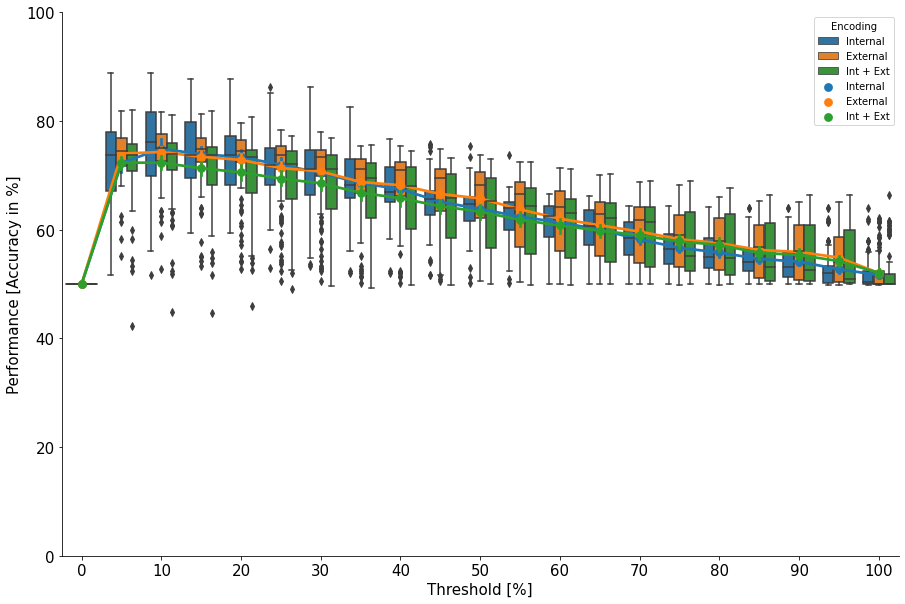

In [30]:
data = bestTHStatsAgents[bestTHStatsAgents['Concept']=='Level Door']

plt.figure(figsize=(15,10))
ax1 = sns.boxplot(data=data,x='TH',y='Accuracy',hue='Encoding')
ax2 = sns.pointplot(data=data,x='TH',y='Accuracy',hue='Encoding')
plt.xlabel('Threshold [%]',fontsize=15)
plt.ylabel('Performance [Accuracy in %]',fontsize=15)
plt.yticks(fontsize=15)
plt.ylim([0,100])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.xticks(np.linspace(0,20,11),np.linspace(0,100,11,dtype=int),fontsize=15)
plt.show()

In [57]:
for e in bestTHStatsAgents['Encoding'].unique():
    data = bestTHStatsAgents[bestTHStatsAgents['Encoding']==e]
    print(e)
    bestTH = 0
    bestTHInd = 0
    for th in np.linspace(0,1,21):
        dataTH = data[data['TH']==np.round(th,2)]
        if np.mean(dataTH['Accuracy']) > bestTH:
            bestTH = np.mean(dataTH['Accuracy'])
            bestTHInd = th
            #print("updated to th = " + str(bestTHInd))
    print("Best TH=" + str(np.round(bestTHInd,2)) + " with mean Accuracy= " + str(bestTH))


Internal
Best TH=0.15 with mean Accuracy= 64.509
External
Best TH=0.05 with mean Accuracy= 60.496333333333325
Int + Ext
Best TH=0.1 with mean Accuracy= 59.64466666666667


In [58]:
numRuns = 100
bestTHStatsA_TH20 = pd.DataFrame(columns = {'Concept','Encoding','Pattern Complexity', 'Examples','NumExp','TH', 
                                        'Accuracy', 'Precision', 'Recall','CPR','F1Score'})
for pattern_complexity in [pattern_complexity_default]:
    for numExp in [numExp_default]:
        for i in range(numRuns):
            print(i)
            allConceptsE = LearnAllConcepts(numExp, pattern_complexity, encExt, to_learn, concept_def)
            allConceptsEI = LearnAllConcepts(numExp, pattern_complexity, encExtInt, to_learn, concept_def)
            allConceptsI = LearnAllConcepts(numExp, pattern_complexity, encInt, to_learn, concept_def)
            
            for c in allConceptsE:
                TH20 = c['CPR_Test'][1]
                bestTHStatsA_TH20 = bestTHStatsA_TH20.append({'Concept': c['Concept'],
                                                                            'Encoding':'External',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.05,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
                     
            for c in allConceptsEI:
                TH20 = c['CPR_Test'][2]
                bestTHStatsA_TH20 = bestTHStatsA_TH20.append({'Concept': c['Concept'],
                                                                            'Encoding':'Ext+Int',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.1,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)

            for c in allConceptsI:
                TH20 = c['CPR_Test'][3]
                bestTHStatsA_TH20 = bestTHStatsA_TH20.append({'Concept': c['Concept'],
                                                                            'Encoding':'Internal',
                                                                            'PC':pattern_complexity,
                                                                            'Examples': c['Examples'],
                                                                            'NumExp':numExp,'TH': 0.15,
                                                                            'Accuracy': TH20[0],
                                                                            'Precision': TH20[1],
                                                                            'Recall': TH20[2],
                                                                            'CPR':TH20[3],'F1Score':TH20[4]},ignore_index=True)
                
                


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [59]:
bestTHStatsA_TH20.to_csv(figurePath+'bestTHStatsAgentsNormx2_IndvTH.csv')